<a href="https://colab.research.google.com/github/parment1/Project-M1-M2/blob/main/Module_1_%26_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [262]:
import pandas as pd
import os
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import statsmodels.api as sm
from functools import reduce
from pandas.tseries.offsets import MonthEnd  
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.stats.diagnostic as dg
from scipy.stats import anderson
from scipy.stats import shapiro
from scipy.stats import normaltest
from sklearn.linear_model import LinearRegression
from numpy import log
 

pd.set_option('display.max_rows',300)


Part I : Data acquisition, formating and cleaning

PART I project: Data acquisition, formating and cleaning

Dataset 1: Download the time series available on NASDAQ website for the Nasdaq Composite index, max history 2011 https://www.nasdaq.com/market-activity/index/ndx/historical

Dataset 2:

-GDP: We use GGP in percent change from preceding Period, quarterly, Seasonally Adjusted Annual Rate: Source: https://fred.stlouisfed.org/tags/series?t=quarterly

-CPI (consumer price inflation): Consumer Price Index: Growth Rate Same Period Previous Year, Monthly, Not Seasonally Adjusted. Source: https://fred.stlouisfed.org/tags/series?t=quarterly

-US Interest rates: Interest rates (%)

-US Unemployment rate Unemployment Rate, Percentfed.org/series/UNRATE

Problem: Do we see a relationship between the stock market and macroeconomic variables


In [263]:
#Open each xls/csv
Nasdaq = pd.read_excel('/content/Nasdaq composite index.xlsx')
#CPI = Consumer price index
CPI = pd.read_excel('/content/CPI monthly.xls')
#Interest_rate = fed fund rate
Interest_rate = pd.read_excel('/content/Fed fund.xls')
GDP = pd.read_excel('/content/GDP.xls')
Unemployment = pd.read_excel('/content/Unemployment.xls')


Explore the strucutre of the different datasets. They all have different shape with monthly data for Unemployment CPI and interest rate, daily for Nasdaq and quarterly for GDP.

We add the monthly percentage change of the Nasdaq



In [264]:
#check size of each dataset
print([Nasdaq.shape,CPI.shape,Interest_rate.shape,GDP.shape,Unemployment.shape])

[(2557, 6), (464, 2), (806, 2), (297, 2), (884, 2)]


In [265]:
#Align the column name for all data set
Nasdaq = Nasdaq.rename(columns={'Date': 'observation_date'})

#Select columns Date & Close/Last date from Nasdaq dataset
Nasdaq = Nasdaq[['observation_date','Close/Last']]
Nasdaq = Nasdaq.iloc[::-1].reset_index(drop=True)

#Get only monthly value for nadsqa (we can use either last day or first day of the month, need to be a trading day)
dates_month = pd.bdate_range(Nasdaq['observation_date'].min(), Nasdaq['observation_date'].max(), freq='1MS')

#Apply bdate range to the Nasdaq DF using isin
Nasdaq_mth = Nasdaq[Nasdaq['observation_date'].isin(dates_month)]
Nasdaq_mth.reset_index(inplace=True,drop=True)

#Calculate monthly return for the Nasdaq timeserie
Nasdaq_mth['Nasdaq composite index return'] =  Nasdaq_mth['Close/Last'].pct_change()*100

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


# Nouvelle section

Each dataset has a column "observation_date", with a different length. The maximum time length publicly available for download is 10 years, we do the following steps

1. we adjust the other data frame to this timeframe for each DF, we set up the end date at end 2019
2. Check the new shape of each DF
3. Merge the different DF into one
4. Simplify the name of the columns

In [266]:
#Select observation period, adjust starting/ending value for different periods

starting_date = '2012-01-01'
ending_date = '2019-12-01'

#Function to select obeservation period, df = dataframe

def select_date(df):
  x = df[(df['observation_date'] >= starting_date) & (df['observation_date'] <= ending_date)]
  x.reset_index(inplace=True,drop=True)
  return x

#Apply to the different dataframe using pipe and create new DF with selected time period
Nasdaq_sample, Interest_rate_sample, CPI_sample, GDP_sample,Unemployment_sample = (df.pipe(select_date)for df in [Nasdaq_mth, Interest_rate,CPI, GDP,Unemployment])


In [267]:
#Check size of dataset after transformation
print([Nasdaq_sample.shape,CPI_sample.shape,Interest_rate_sample.shape,GDP_sample.shape,Unemployment_sample.shape])

[(95, 3), (96, 2), (96, 2), (32, 2), (96, 2)]


In [268]:
Nasdaq_sample

observation_date  Close/Last  Nasdaq composite index return
0        2012-01-01     2277.83                      -1.358479
1        2012-02-01     2488.18                       9.234666
2        2012-03-01     2643.54                       6.243921
3        2012-04-01     2784.42                       5.329218
4        2012-05-01     2726.92                      -2.065062
5        2012-06-01     2458.83                      -9.831238
6        2012-07-01     2625.03                       6.759312
7        2012-08-01     2635.13                       0.384758
8        2012-09-01     2772.24                       5.203159
9        2012-10-01     2794.28                       0.795025
10       2012-11-01     2687.52                      -3.820662
11       2012-12-01     2671.84                      -0.583438
12       2013-01-01     2660.93                      -0.408333
13       2013-02-01     2763.96                       3.871955
14       2013-03-01     2747.75                      -0.586477
15       2013-04-01     2797.07                       1.794923
16       2013-05-01     2873.35                       2.727139
17       2013-06-01     2990.79                       4.087215
18       2013-07-01     2927.35                      -2.121179
19       2013-08-01     3126.30                       6.796249
20       2013-09-01     3073.81                      -1.678982
21       2013-10-01     3253.05                       5.831200
22       2013-11-01     3379.76                       3.895114
23       2013-12-01     3481.15                       2.999917
24       2014-01-01     3592.00                       3.184293
25       2014-02-01     3440.50                      -4.217706
26       2014-03-01     3668.37                       6.623165
27       2014-04-01     3658.40                      -0.271783
28       2014-05-01     3594.36                      -1.750492
29       2014-06-01     3732.96                       3.856041
30       2014-07-01     3894.33                       4.322843
31       2014-08-01     3879.67                      -0.376445
32       2014-09-01     4082.56                       5.229568
33       2014-10-01     3984.74                      -2.396046
34       2014-11-01     4169.28                       4.631168
35       2014-12-01     4287.81                       2.842937
36       2015-01-01     4236.28                      -1.201779
37       2015-02-01     4188.59                      -1.125752
38       2015-03-01     4483.05                       7.030051
39       2015-04-01     4311.26                      -3.831989
40       2015-05-01     4479.06                       3.892134
41       2015-06-01     4521.85                       0.955334
42       2015-07-01     4429.23                      -2.048277
43       2015-08-01     4580.46                       3.414363
44       2015-09-01     4142.63                      -9.558647
45       2015-10-01     4192.96                       1.214929
46       2015-11-01     4703.91                      12.185902
47       2015-12-01     4716.16                       0.260422
48       2016-01-01     4497.86                      -4.628766
49       2016-02-01     4286.56                      -4.697790
50       2016-03-01     4333.61                       1.097617
51       2016-04-01     4532.08                       4.579785
52       2016-05-01     4381.30                      -3.326949
53       2016-06-01     4520.07                       3.167325
54       2016-07-01     4437.44                      -1.828069
55       2016-08-01     4756.04                       7.179815
56       2016-09-01     4783.94                       0.586622
57       2016-10-01     4866.63                       1.728492
58       2016-11-01     4766.94                      -2.048440
59       2016-12-01     4734.10                      -0.688912
60       2017-01-01     4911.33                       3.743689
61       2017-02-01     5152.69                       4.914351
62       2017-03-01     5390.99   

In [311]:
data_frames = [Nasdaq_sample,CPI_sample,Interest_rate_sample,Unemployment_sample,GDP_sample]

#Merge all DF into one based on "observation date" using the function melt, keep N/A if any

df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['observation_date'],
                                            how='left'), data_frames)

#drop the column Close/Last and set "observation date" as index
df_merged_ = df_merged.drop('Close/Last', axis = 1)
df_merged_clean = df_merged_.set_index('observation_date')

#fillna 
#df_merged_clean = df_merged_clean.fillna(method='bfill')
#method='bfill'
#See column name
columns = df_merged_clean.columns
columns

Index(['Nasdaq composite index return', 'CPI (%)', 'Interest rate (%)',
       'Unemployment Rate (%)', 'Gross Domestic Product (%)'],
      dtype='object')

In [312]:
#test:

df_test = df_merged_clean.interpolate(method='linear', limit_direction ='forward')
# to interpolate the missing values

Text(0.5, 1.0, 'Gross Domestic Product')

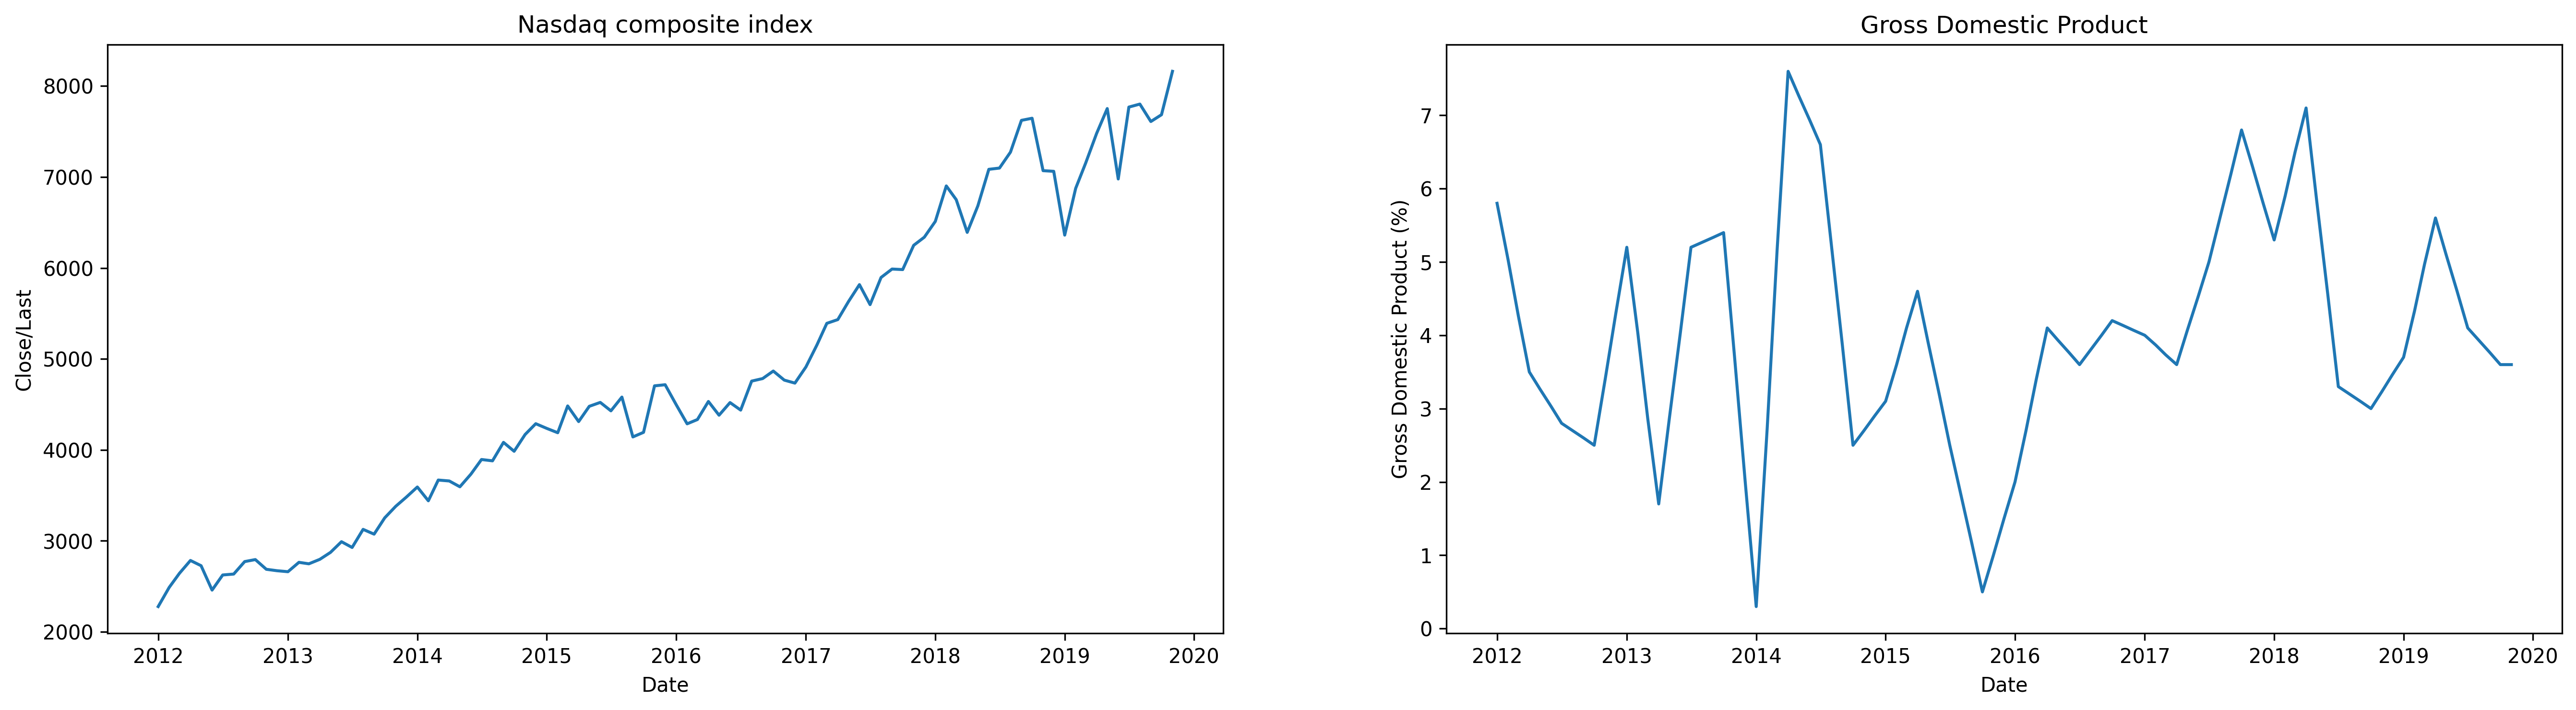

In [313]:
# Line plots
fig1 = plt.figure(figsize=(22, 10),dpi=300)

left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 1      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.2   # the amount of height reserved for white space between subplots
fig1.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

ax1 = fig1.add_subplot(221)
sns.lineplot(
    data=df_merged, 
#     kind="line",
    x='observation_date', 
    y="Close/Last")
plt.xlabel('Date')
plt.title('Nasdaq composite index')

ax2 = fig1.add_subplot(222)
sns.lineplot(
    data=df_test, 
#     kind="line",
    x='observation_date', 
    y="Gross Domestic Product (%)")
plt.xlabel('Date')
plt.title('Gross Domestic Product')

 A useful analyis of TS is to break the TS into systematic and unsystematic components:
        -Systematic: Components of the TS that have consistency or recurrence and can be described and model We have three systematic components:
             -Level: The average value in the series
             -Trend: The increasing or decreasing value in the series
             -Seasonality: The repeating short-term cycle in the series
        -Non-systematic: components of the time series that cannot be directly modeled
            -Noise: The random variation in the series

        A serie is the combination of the 4 elements. They can be additive our multiplicative.
        Additive model: y(t) = Level + trend + seasonality + noise (linear model)
        Mutliplicative model: y(t) = Level * trend * seasonality * noise (non linear model, changes increase or decrease over time, curved line)

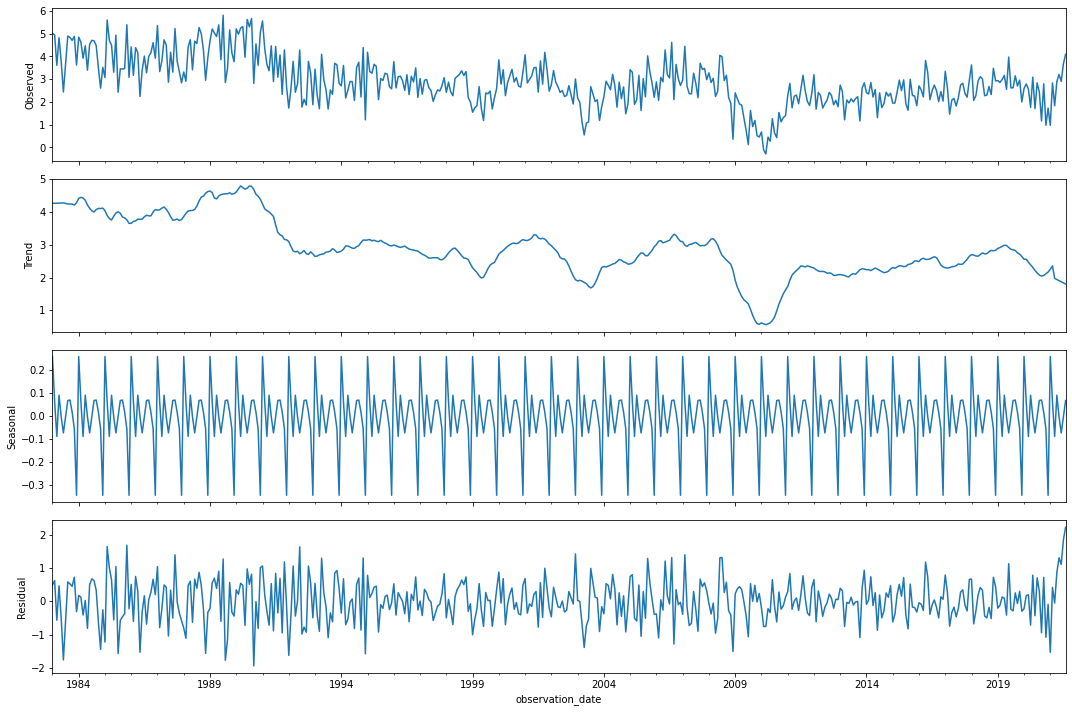

In [272]:
#Additive and multiplicative decomposition, reload the data without header and index_col, easiest method I foud to use  Seasonal decomposition:
Nasdaq_ = pd.read_excel('/content/Nasdaq composite index.xlsx', header=0,index_col=0)
CPI_ = pd.read_excel('/content/CPI monthly.xls', header=0,index_col=0)
Interest_rate_ = pd.read_excel('/content/Fed fund.xls',header=0,index_col=0)
GDP_ = pd.read_excel('/content/GDP.xls',header=0,index_col=0)
Unemployment_ = pd.read_excel('/content/Unemployment.xls',header=0,index_col=0)

def seasonal_dec(df,model,extrapolate_Trend):
        result = seasonal_decompose(df, model = model,extrapolate_trend=extrapolate_Trend)
        plt.rcParams['figure.figsize'] = [15, 10]
        result.plot()
        plt.show()

CPI_decompose = seasonal_dec(CPI_,'Additive Decompose','freq')

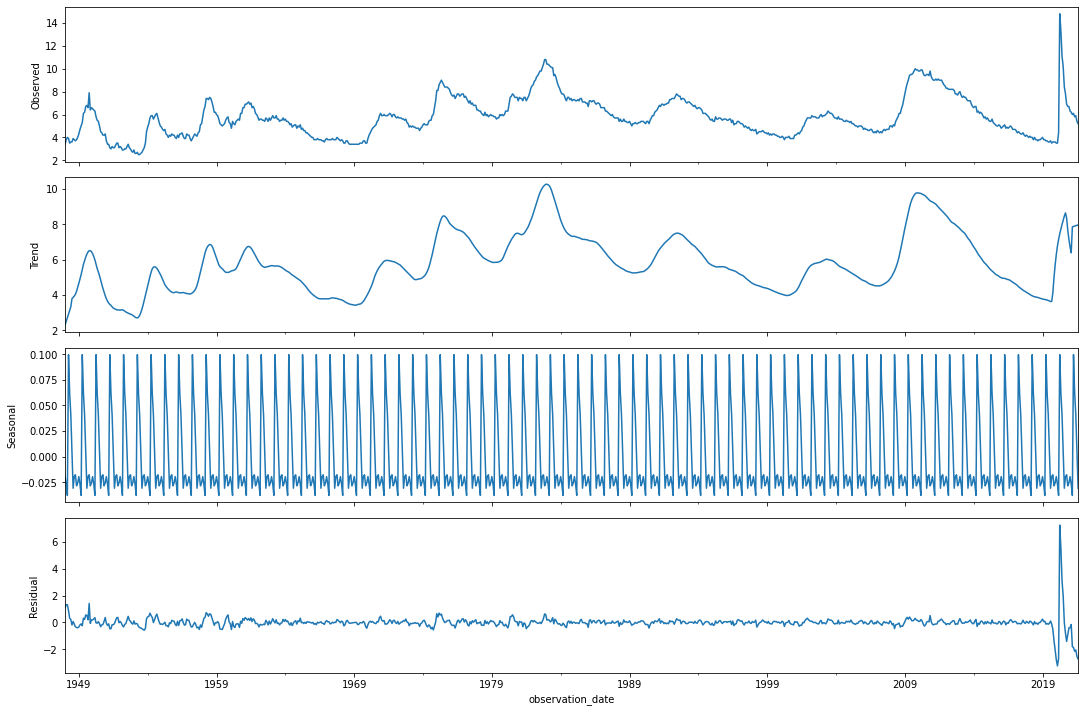

In [273]:
Unemployment_decompose = seasonal_dec(Unemployment_,'Additive Decompose','freq')

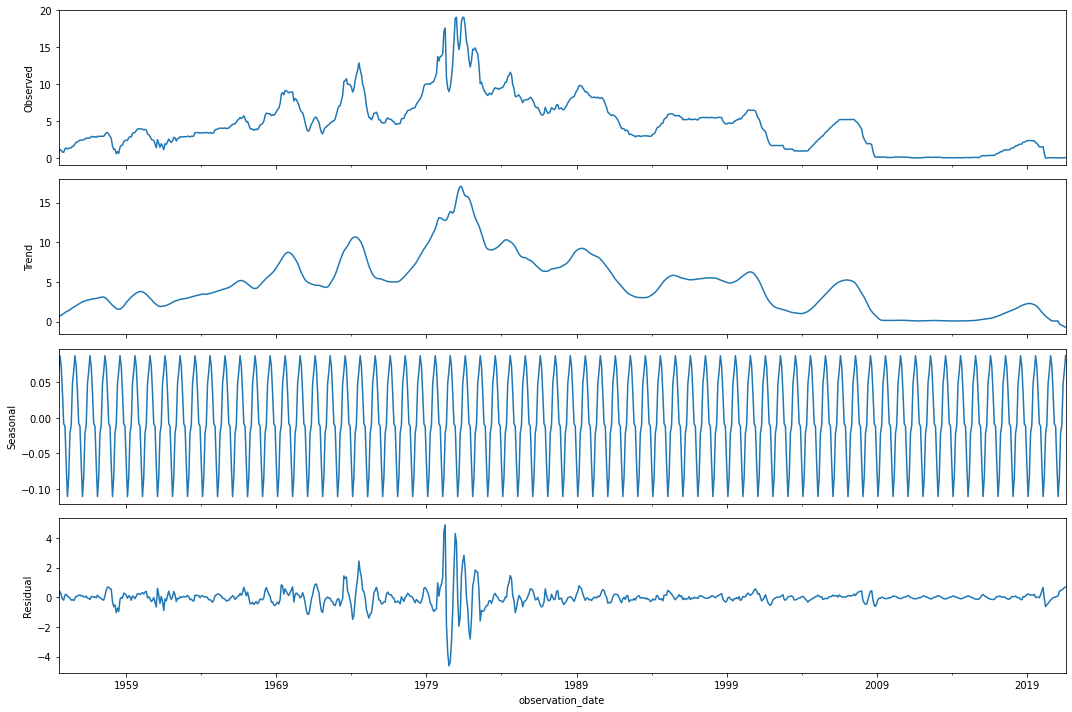

In [274]:
IR_decompose = seasonal_dec(Interest_rate_,'Additive Decompose','freq')

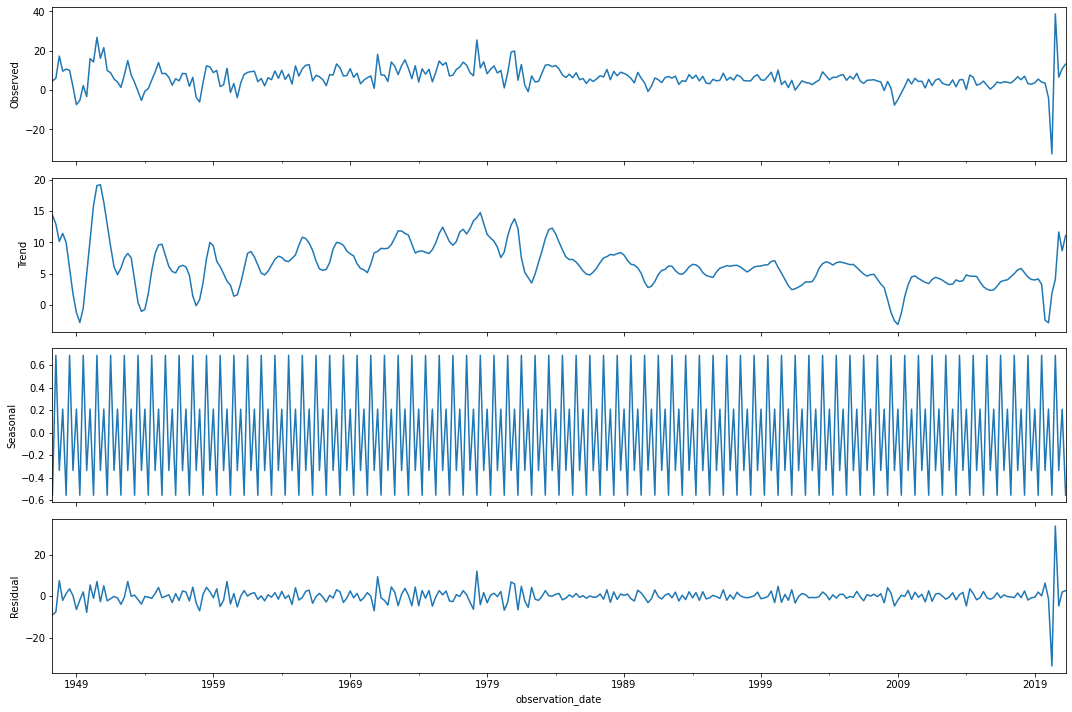

In [275]:
GDP_decompose = seasonal_dec(GDP_,'Additive Decompose','freq')

In [314]:
df_merged_clean.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 95 entries, 2012-01-01 to 2019-11-01
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Nasdaq composite index return  95 non-null     float64
 1   CPI (%)                        95 non-null     float64
 2   Interest rate (%)              95 non-null     float64
 3   Unemployment Rate (%)          95 non-null     float64
 4   Gross Domestic Product (%)     32 non-null     float64
dtypes: float64(5)
memory usage: 4.5 KB


In [315]:
df_merged_clean.isna().sum()


Nasdaq composite index return     0
CPI (%)                           0
Interest rate (%)                 0
Unemployment Rate (%)             0
Gross Domestic Product (%)       63
dtype: int64

In [278]:
df_merged_clean.head(20)

Nasdaq composite index return  ...  Gross Domestic Product (%)
observation_date                                 ...                            
2012-01-01                            -1.358479  ...                         5.8
2012-02-01                             9.234666  ...                         NaN
2012-03-01                             6.243921  ...                         NaN
2012-04-01                             5.329218  ...                         3.5
2012-05-01                            -2.065062  ...                         NaN
2012-06-01                            -9.831238  ...                         NaN
2012-07-01                             6.759312  ...                         2.8
2012-08-01                             0.384758  ...                         NaN
2012-09-01                             5.203159  ...                         NaN
2012-10-01                             0.795025  ...                         2.5
2012-11-01                            -3.820662  ...                         NaN
2012-12-01                            -0.583438  ...                         NaN
2013-01-01                            -0.408333  ...                         5.2
2013-02-01                             3.871955  ...                         NaN
2013-03-01                            -0.586477  ...                         NaN
2013-04-01                             1.794923  ...                         1.7
2013-05-01                             2.727139  ...                         NaN
2013-06-01                             4.087215  ...                         NaN
2013-07-01                            -2.121179  ...                         5.2
2013-08-01                             6.796249  ...                         NaN

[20 rows x 5 columns]


Part II: Descriptive analysis

-Check how dataset looks like
-Plot the different dataset
-Correlation matrix
-Cointegration matrix
-Test

Check how the data are distrbitued with  a kernel density estimate to smooth the histogram



In [279]:
df_columns = df_merged_clean.columns


In [280]:
df_merged_clean = df_merged_clean[['Nasdaq composite index return','CPI (%)','Interest rate (%)', 'Unemployment Rate (%)','Gross Domestic Product (%)']]

In [317]:
df_columns_= df_merged_clean.columns
df_merged_clean = df_merged_clean.fillna(method="ffill")
df_merged_clean.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 95 entries, 2012-01-01 to 2019-11-01
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Nasdaq composite index return  95 non-null     float64
 1   CPI (%)                        95 non-null     float64
 2   Interest rate (%)              95 non-null     float64
 3   Unemployment Rate (%)          95 non-null     float64
 4   Gross Domestic Product (%)     95 non-null     float64
dtypes: float64(5)
memory usage: 4.5 KB


In [318]:
df_merged_clean.head()

Nasdaq composite index return  ...  Gross Domestic Product (%)
observation_date                                 ...                            
2012-01-01                            -1.358479  ...                         5.8
2012-02-01                             9.234666  ...                         5.8
2012-03-01                             6.243921  ...                         5.8
2012-04-01                             5.329218  ...                         3.5
2012-05-01                            -2.065062  ...                         3.5

[5 rows x 5 columns]

Text(0.5, 1.0, 'Unemployment rate (%)')

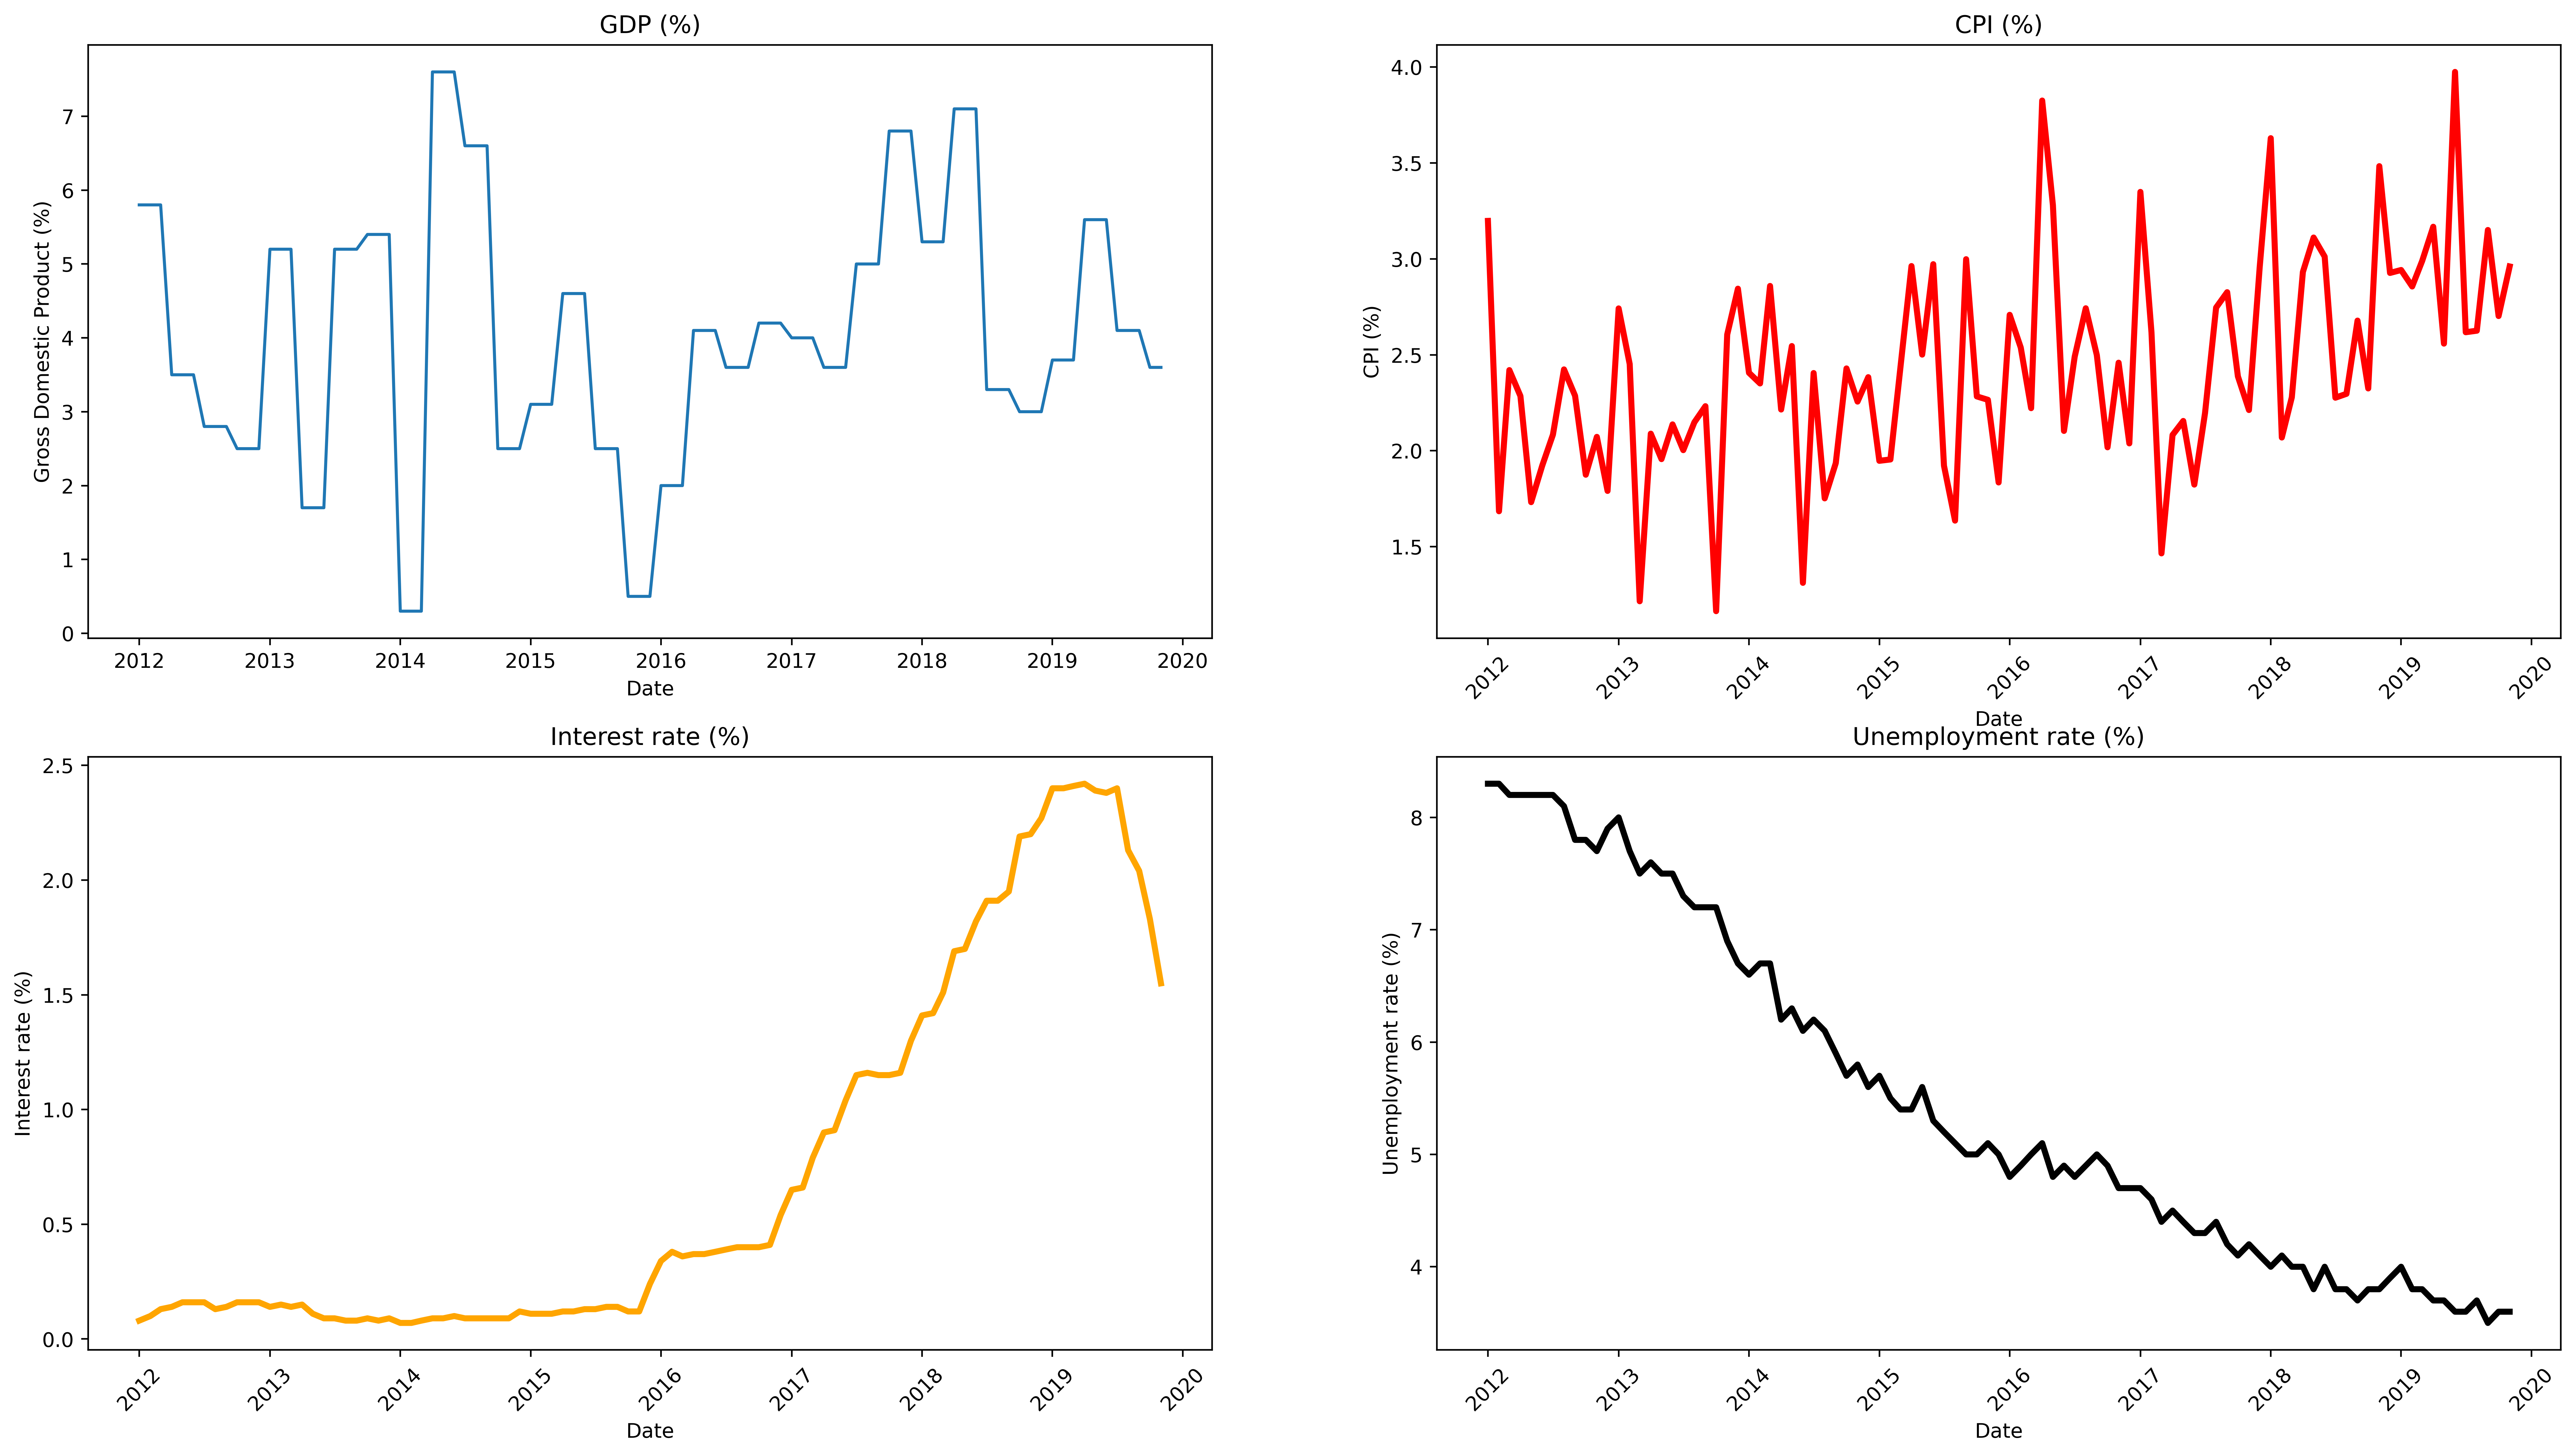

In [282]:
# Line plots
fig1 = plt.figure(figsize=(22, 10),dpi=500)

left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 1      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.2   # the amount of height reserved for white space between subplots
fig1.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

ax1 = fig1.add_subplot(221)
sns.lineplot(
    data=df_merged_clean, 
#     kind="line",
    x=df_merged_clean.index, 
    y="Gross Domestic Product (%)")
plt.xlabel('Date')
plt.title('GDP (%)')

ax2 = fig1.add_subplot(222)
sns.lineplot(
    data=df_merged_clean, 
    x=df_merged_clean.index, 
    y="CPI (%)",
    ax = ax2,
    linewidth = 3,
    color = 'red')
plt.xticks(rotation=45) 
plt.ylabel('CPI (%)')
plt.xlabel('Date')
plt.title('CPI (%)')

ax3 = fig1.add_subplot(223)
sns.lineplot(
    data=df_merged_clean, 
    x=df_merged_clean.index, 
    y="Interest rate (%)",
    ax = ax3,
    linewidth = 3,
    color = 'orange')
plt.xticks(rotation=45) 
plt.ylabel('Interest rate (%)')
plt.xlabel('Date')
plt.title('Interest rate (%)')

ax4 = fig1.add_subplot(224)
sns.lineplot(
    data=df_merged_clean, 
    x=df_merged_clean.index, 
    y="Unemployment Rate (%)",
    ax = ax4,
    linewidth = 3,
    color = 'black')
plt.xticks(rotation=45) 
plt.ylabel('Unemployment rate (%)')
plt.xlabel('Date')
plt.title('Unemployment rate (%)')



In [283]:
round(df_merged_clean.describe(),2)

Nasdaq composite index return  ...  Gross Domestic Product (%)
count                          95.00  ...                       95.00
mean                            1.43  ...                        4.03
std                             4.40  ...                        1.76
min                            -9.98  ...                        0.30
25%                            -1.28  ...                        2.90
50%                             1.57  ...                        4.00
75%                             4.56  ...                        5.25
max                            12.19  ...                        7.60

[8 rows x 5 columns]

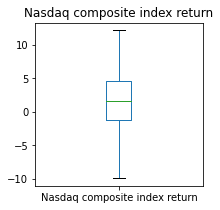

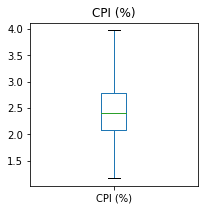

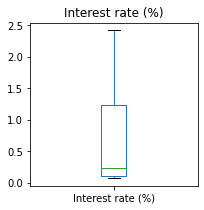

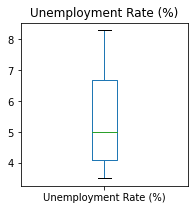

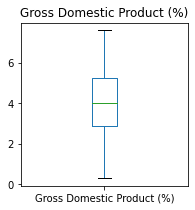

In [284]:
for i in df_columns:
  df_merged_clean[i].plot(kind='box',figsize=(3,3), title=i,whis=2)
  plt.show()

In [285]:
df_merged_clean = df_merged_clean.fillna(method='bfill')

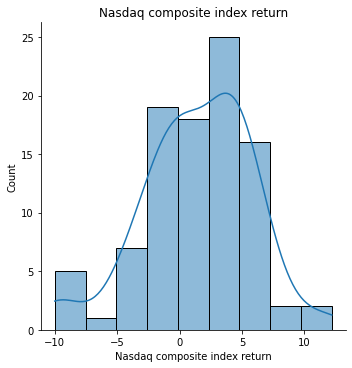

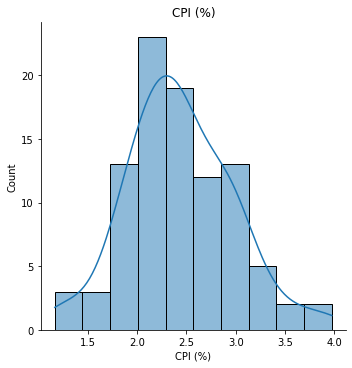

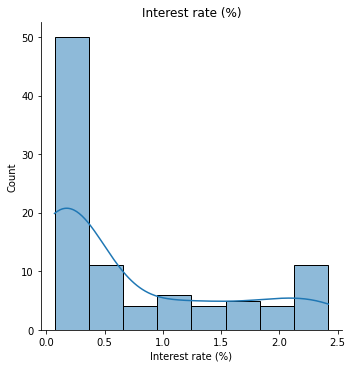

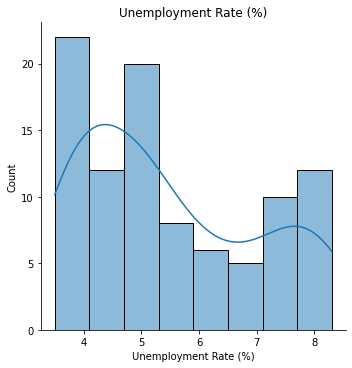

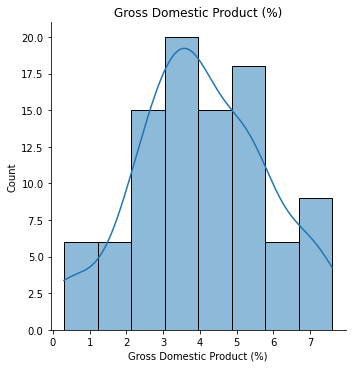

In [286]:
#Visualisation data distribution
for i in df_columns:
  sns.displot(df_merged_clean, x=i,kde=True)
  plt.title(i)

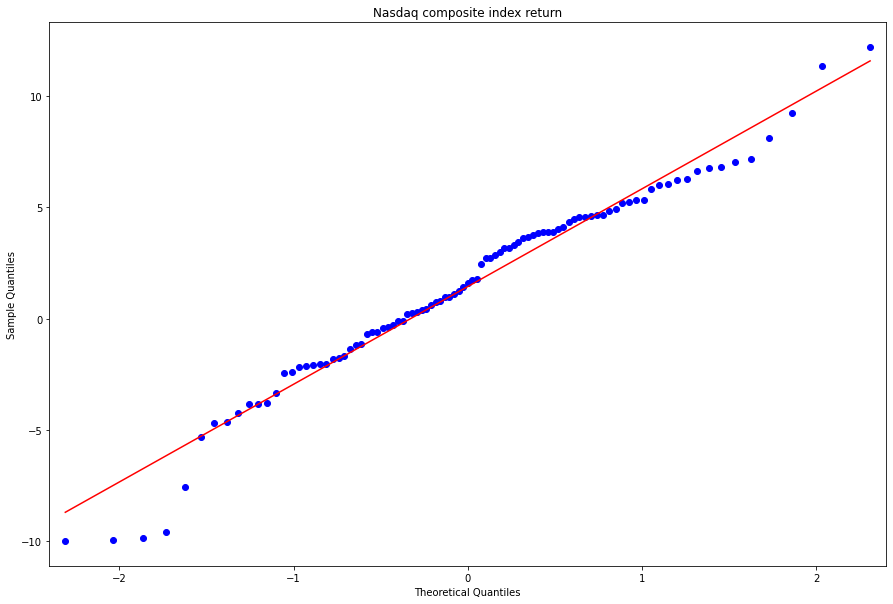

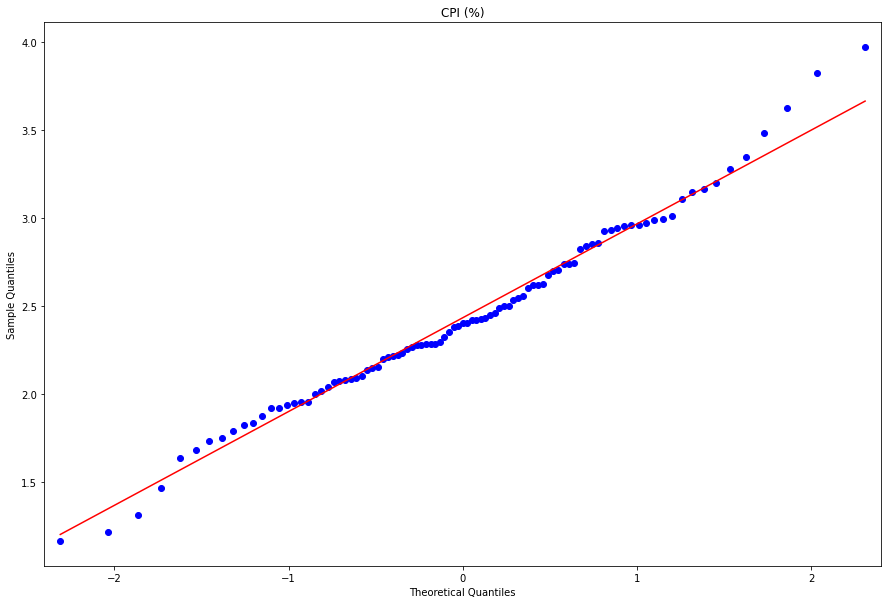

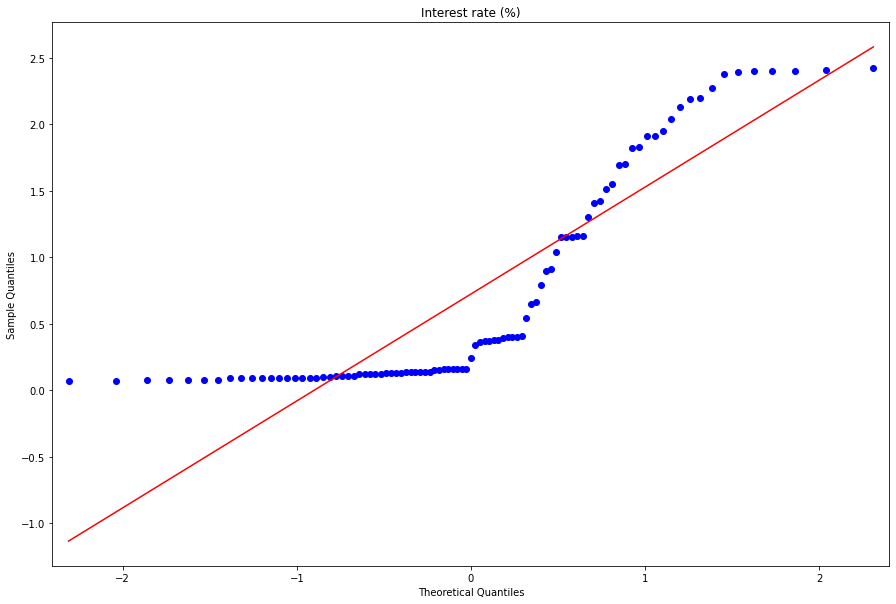

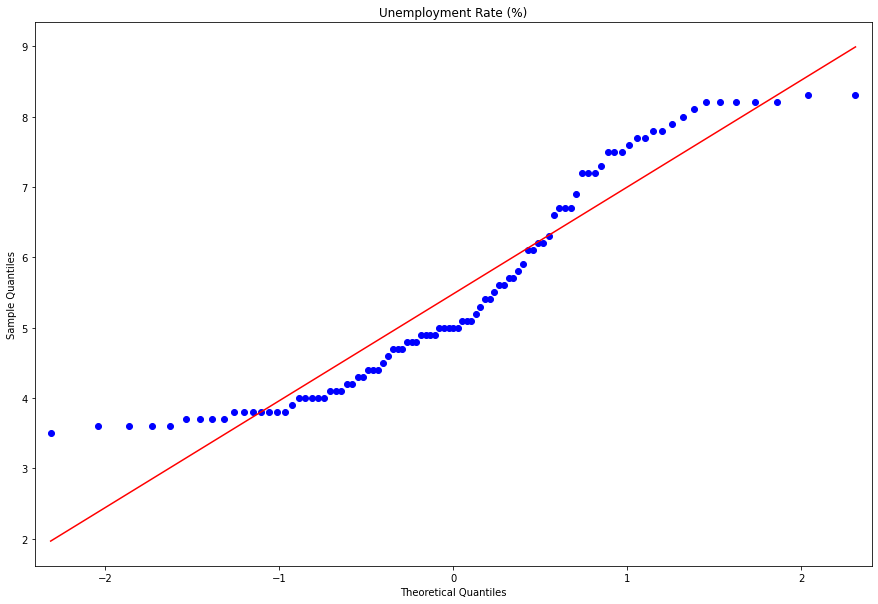

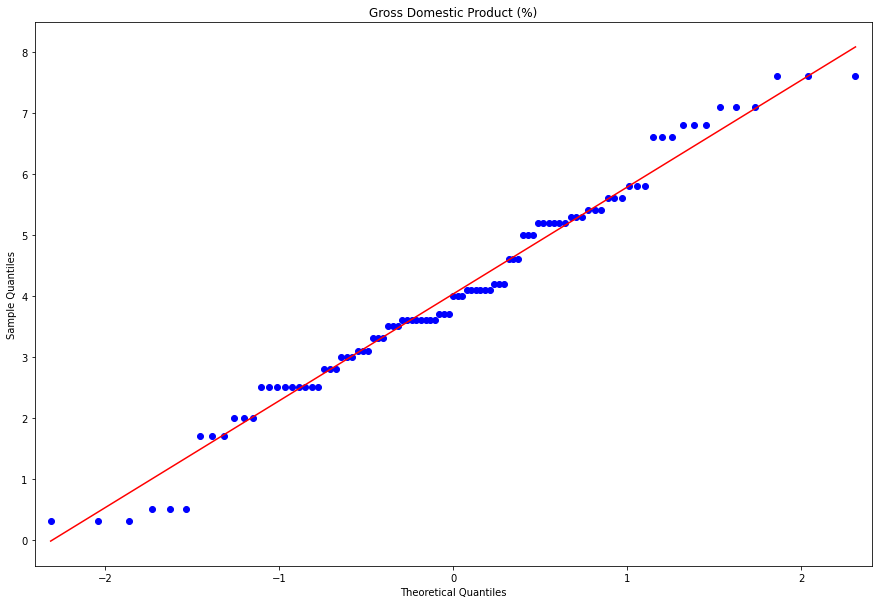

In [287]:
#checking the distribution of a data sample iwiths the quantile-quantile plot, Q-Q plot
for i in df_columns:
  qqplot(df_merged_clean[i], line='s')
  plt.title(i)
  plt.show()


In [288]:
# Anderson Test for Gaussian distribution
for i in df_columns: 
  result = anderson(df_merged_clean[i])
  print(' ')
  print(i + ' Statistic: %.3f' % result.statistic)
  p = 0
  for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
      print(' %.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
      print(' %.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

 
Nasdaq composite index return Statistic: 0.685
 15.000: 0.554, data does not look normal (reject H0)
 10.000: 0.631, data does not look normal (reject H0)
 5.000: 0.757, data looks normal (fail to reject H0)
 2.500: 0.883, data looks normal (fail to reject H0)
 1.000: 1.051, data looks normal (fail to reject H0)
 
CPI (%) Statistic: 0.350
 15.000: 0.554, data looks normal (fail to reject H0)
 10.000: 0.631, data looks normal (fail to reject H0)
 5.000: 0.757, data looks normal (fail to reject H0)
 2.500: 0.883, data looks normal (fail to reject H0)
 1.000: 1.051, data looks normal (fail to reject H0)
 
Interest rate (%) Statistic: 9.384
 15.000: 0.554, data does not look normal (reject H0)
 10.000: 0.631, data does not look normal (reject H0)
 5.000: 0.757, data does not look normal (reject H0)
 2.500: 0.883, data does not look normal (reject H0)
 1.000: 1.051, data does not look normal (reject H0)
 
Unemployment Rate (%) Statistic: 3.060
 15.000: 0.554, data does not look normal (re

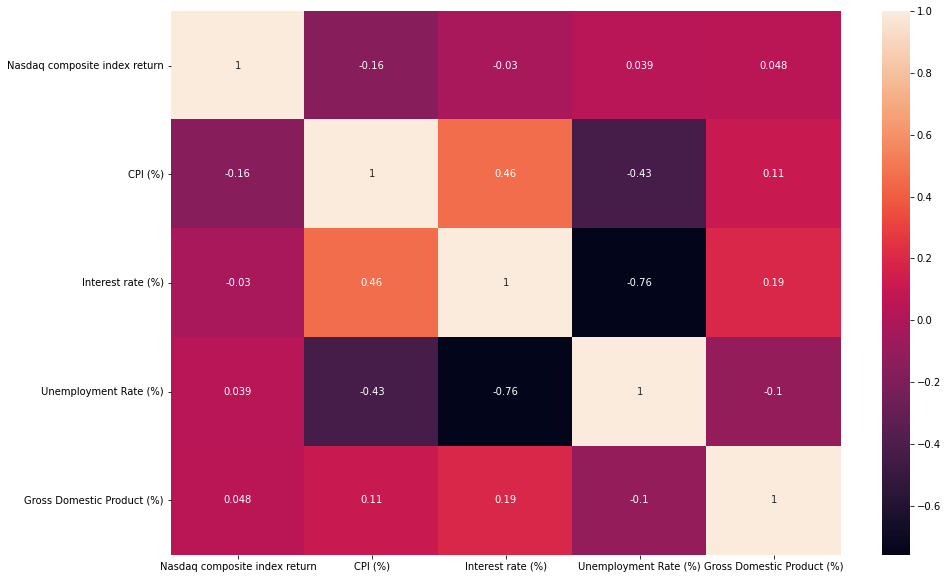

In [289]:
#Create correlation matrix 
corrMatrix = df_merged_clean.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

When dealing with time series data, it is important to examine the existence of unit root in the  data series.  A non-stationary process generates the problem of  spurious regression between unrelated variables. We use the Augmented Dickey-Fuller (ADF) test. 


In [290]:
#Function for the ADF test
def ADF_test(DF,columns):
  #DF = dataframe
  #columns = columns of DF
  for i in columns:
    X = DF[i].values
    result = adfuller(X)
    print(i)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
      print('\t%s: %.3f' % (key, value))

#function of the ADF test to smooth the data a bit more
def ADF_log_test(DF,columns):
  for i in columns:
    X = DF[i].values
    X = log(X)
    X = X[np.logical_not(np.isnan(X))]
    result = adfuller(X)
    print(i + ' ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
      print('\t%s: %.3f' % (key, value))

ADF_test(df_merged_clean,df_columns)

Nasdaq composite index return
ADF Statistic: -8.743892
p-value: 0.000000
Critical Values:
	1%: -3.503
	5%: -2.893
	10%: -2.584
CPI (%)
ADF Statistic: -2.180978
p-value: 0.213222
Critical Values:
	1%: -3.505
	5%: -2.894
	10%: -2.584
Interest rate (%)
ADF Statistic: -3.805337
p-value: 0.002853
Critical Values:
	1%: -3.512
	5%: -2.897
	10%: -2.586
Unemployment Rate (%)
ADF Statistic: -2.738051
p-value: 0.067682
Critical Values:
	1%: -3.504
	5%: -2.894
	10%: -2.584
Gross Domestic Product (%)
ADF Statistic: -2.288108
p-value: 0.175832
Critical Values:
	1%: -3.507
	5%: -2.895
	10%: -2.585


In [291]:
#Once we executed the ADF test, we first difference the independent variables wehere the time series is non-stationary
columns = ['CPI (%)','Interest rate (%)','Unemployment Rate (%)','Gross Domestic Product (%)']
df_merged_clean_first_difference = df_merged_clean[columns].diff().dropna()
df_columns_first_difference = df_merged_clean_first_difference.columns

ADF_test(df_merged_clean_first_difference,df_columns_first_difference)

CPI (%)
ADF Statistic: -6.699819
p-value: 0.000000
Critical Values:
	1%: -3.507
	5%: -2.895
	10%: -2.585
Interest rate (%)
ADF Statistic: -0.763394
p-value: 0.829639
Critical Values:
	1%: -3.512
	5%: -2.897
	10%: -2.586
Unemployment Rate (%)
ADF Statistic: -1.738980
p-value: 0.411149
Critical Values:
	1%: -3.514
	5%: -2.898
	10%: -2.586
Gross Domestic Product (%)
ADF Statistic: -8.108032
p-value: 0.000000
Critical Values:
	1%: -3.507
	5%: -2.895
	10%: -2.585


Text(0.5, 1.0, 'Unemployment rate (%)')

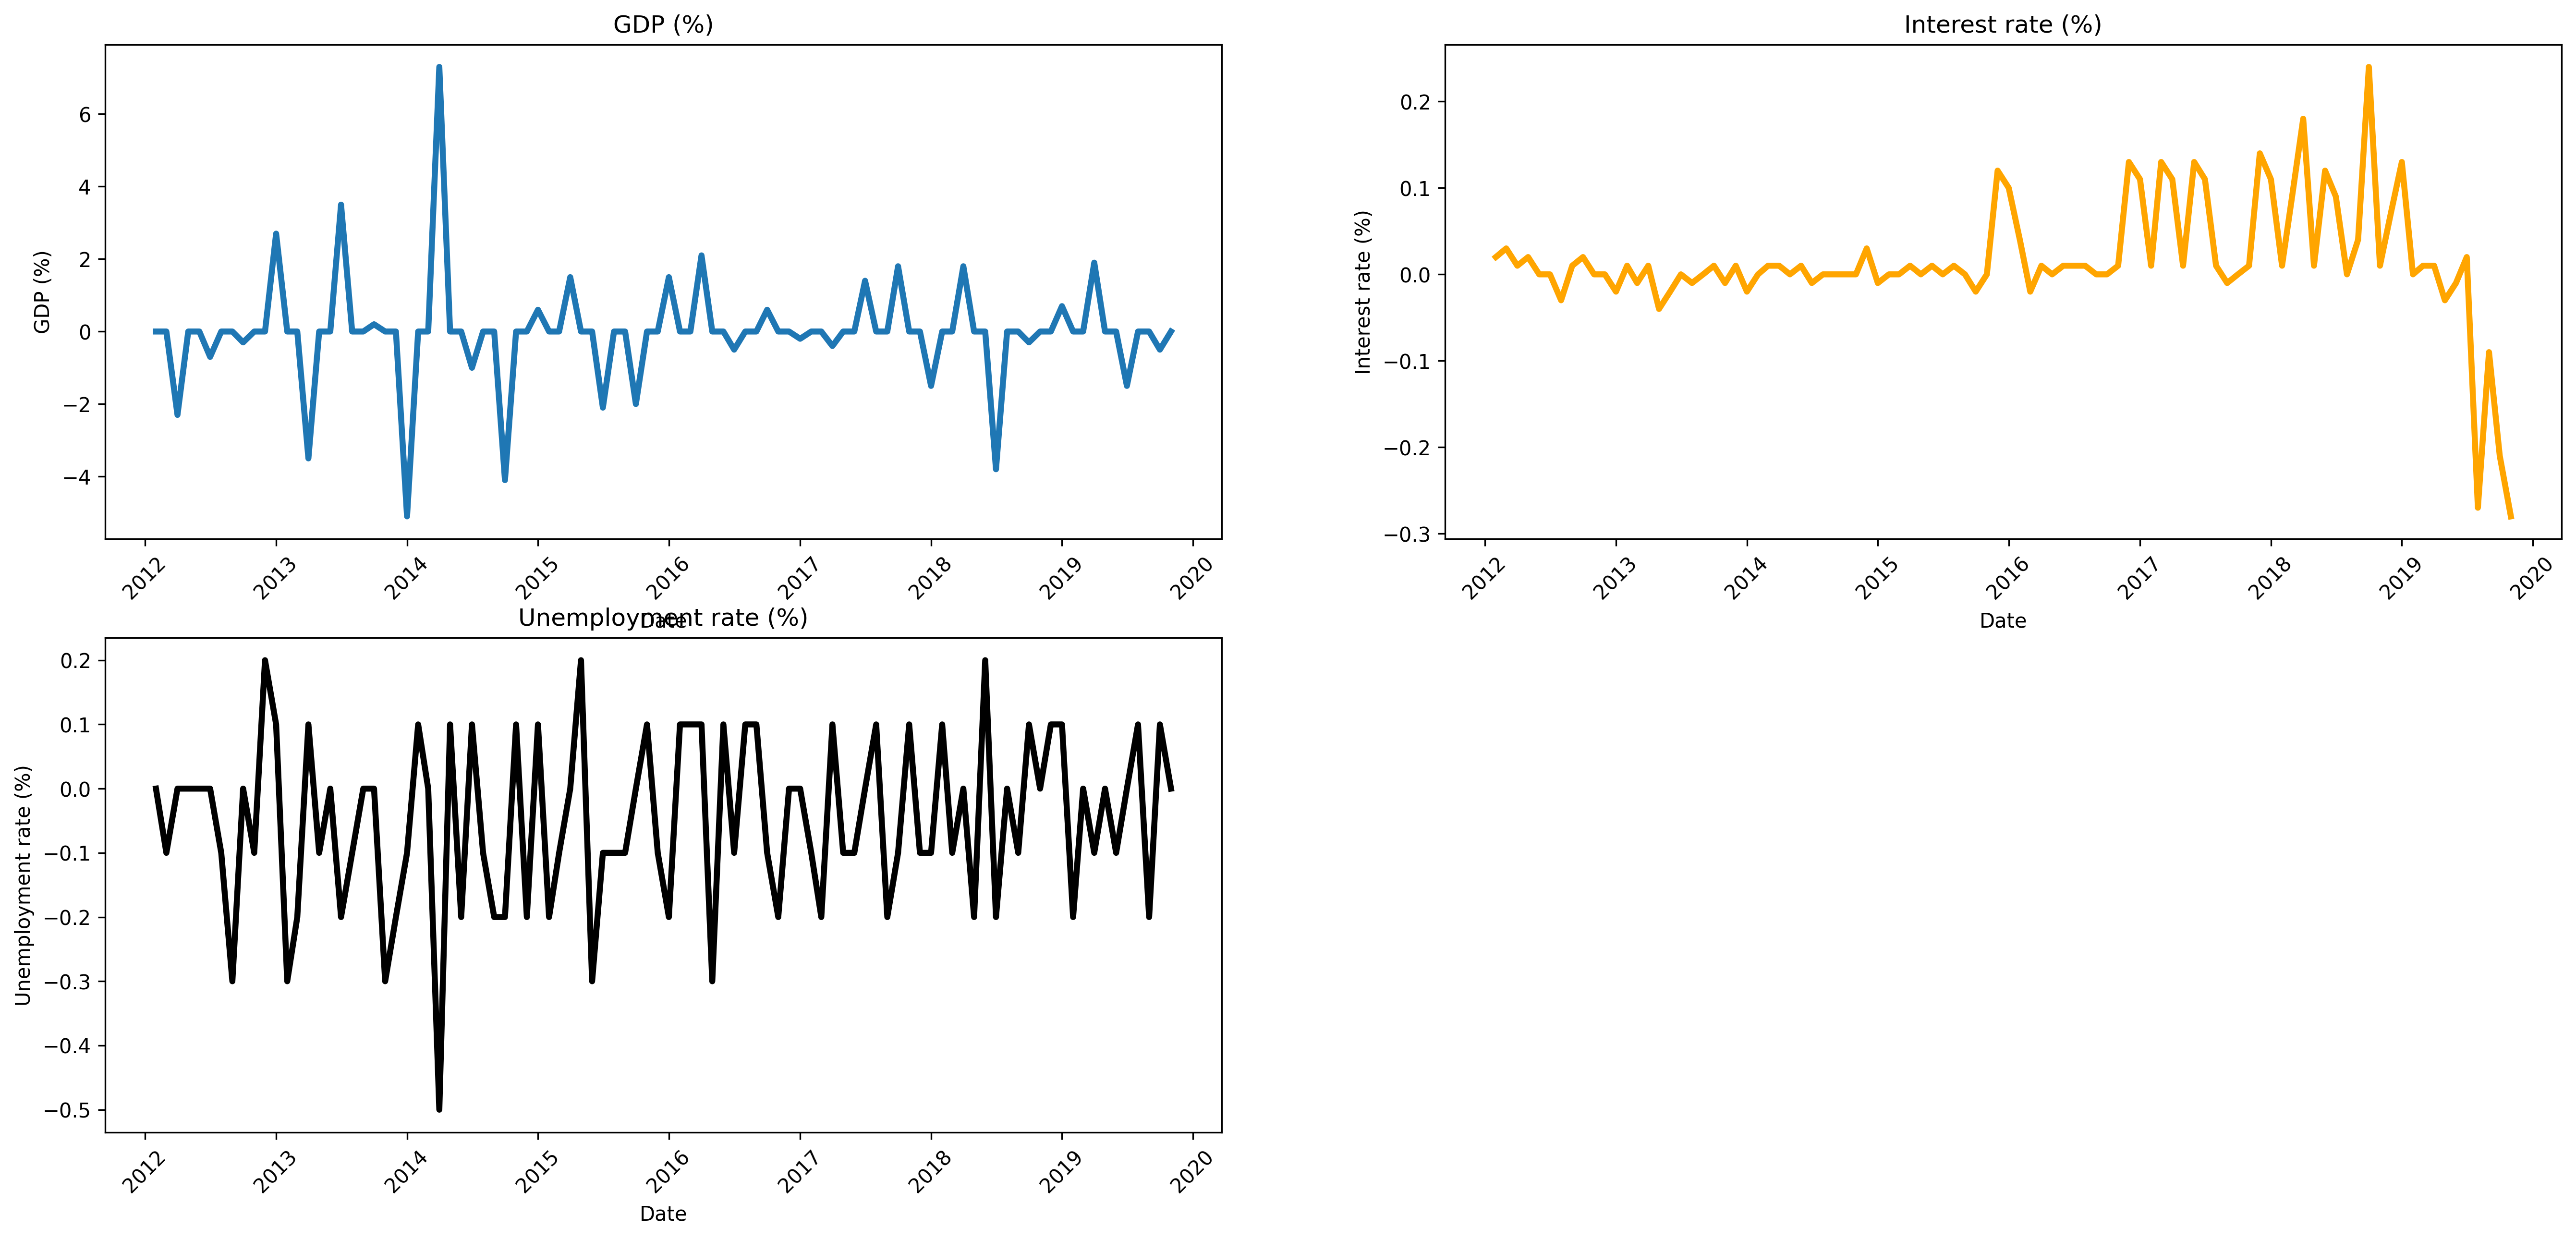

In [292]:
# Line plots
fig2 = plt.figure(figsize=(22, 10),dpi=300)

left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 1      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.2   # the amount of height reserved for white space between subplots
fig1.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

ax1 = fig2.add_subplot(221)
sns.lineplot(
    data=df_merged_clean_first_difference, 
#     kind="line",
    x=df_merged_clean_first_difference.index, 
    y="Gross Domestic Product (%)",
    ax = ax1,
    linewidth = 3)
plt.xticks(rotation=45) 
plt.ylabel('GDP (%)')
plt.xlabel('Date')
plt.title('GDP (%)')

ax2 = fig2.add_subplot(222)
sns.lineplot(
    data=df_merged_clean_first_difference, 
    x=df_merged_clean_first_difference.index, 
    y="Interest rate (%)",
    ax = ax2,
    linewidth = 3,
    color = 'orange')
plt.xticks(rotation=45) 
plt.ylabel('Interest rate (%)')
plt.xlabel('Date')
plt.title('Interest rate (%)')

ax3 = fig2.add_subplot(223)
sns.lineplot(
    data=df_merged_clean_first_difference, 
    x=df_merged_clean_first_difference.index, 
    y="Unemployment Rate (%)",
    ax = ax3,
    linewidth = 3,
    color = 'black')
plt.xticks(rotation=45) 
plt.ylabel('Unemployment rate (%)')
plt.xlabel('Date')
plt.title('Unemployment rate (%)')


In [293]:
#We re-do the same and look for the second difference for the independent variables still non-stationary even after first-difference
columns_second = ['Unemployment Rate (%)','Interest rate (%)']
df_merged_clean_second_difference = df_merged_clean_first_difference[columns_second].diff().dropna()
df_columns_second_difference = df_merged_clean_second_difference.columns
ADF_test(df_merged_clean_second_difference,df_columns_second_difference)

Unemployment Rate (%)
ADF Statistic: -3.784562
p-value: 0.003069
Critical Values:
	1%: -3.515
	5%: -2.898
	10%: -2.586
Interest rate (%)
ADF Statistic: -1.961932
p-value: 0.303510
Critical Values:
	1%: -3.512
	5%: -2.897
	10%: -2.586


Text(0.5, 1.0, 'Unemployment rate (%)')

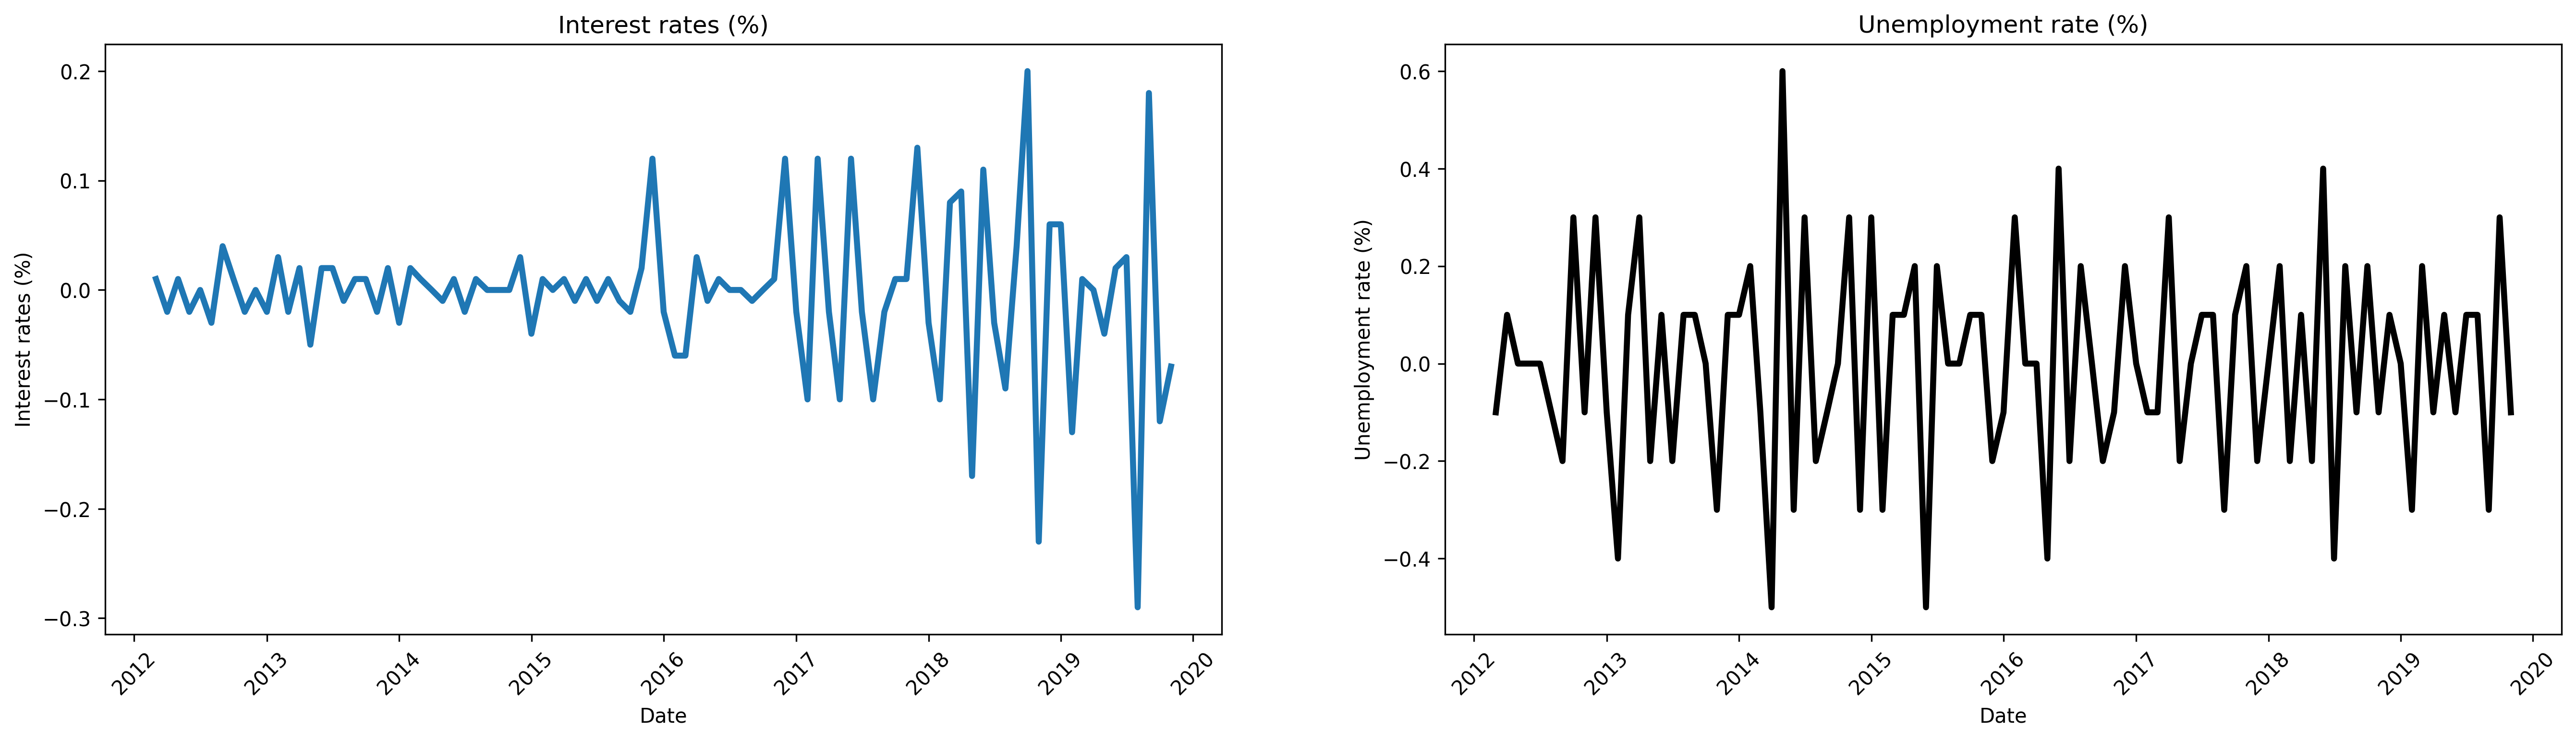

In [294]:
# Line plots
fig3 = plt.figure(figsize=(22, 10),dpi=300)
fig3.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

ax1 = fig3.add_subplot(221)
sns.lineplot(
    data=df_merged_clean_second_difference, 
    x=df_merged_clean_second_difference.index, 
    y="Interest rate (%)",
    ax = ax1,
    linewidth = 3)
plt.xticks(rotation=45) 
plt.ylabel('Interest rates (%)')
plt.xlabel('Date')
plt.title('Interest rates (%)')

ax2 = fig3.add_subplot(222)
sns.lineplot(
    data=df_merged_clean_second_difference, 
    x=df_merged_clean_second_difference.index, 
    y="Unemployment Rate (%)",
    ax = ax2,
    linewidth = 3,
    color = 'black')
plt.xticks(rotation=45) 
plt.ylabel('Unemployment rate (%)')
plt.xlabel('Date')
plt.title('Unemployment rate (%)')

In [295]:
#We re-do the same and look for the second difference for the independent variables still non-stationary even after first-difference
columns_third = ['Interest rate (%)']
df_merged_clean_third_difference = df_merged_clean_second_difference[columns_third].diff().dropna()
df_columns_third_difference = df_merged_clean_third_difference.columns
ADF_test(df_merged_clean_third_difference,df_columns_third_difference)

Interest rate (%)
ADF Statistic: -4.498220
p-value: 0.000198
Critical Values:
	1%: -3.513
	5%: -2.897
	10%: -2.586


Text(0.5, 1.0, 'Interest rate (%)')

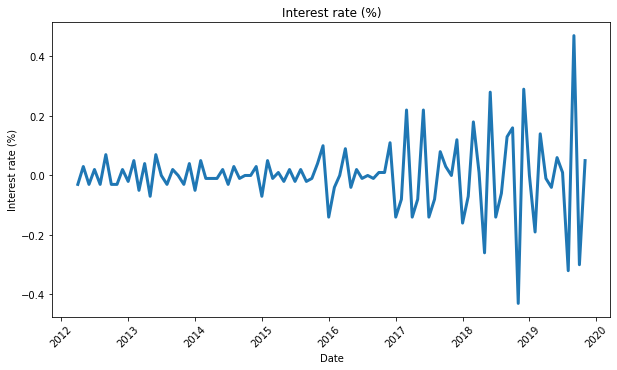

In [296]:
# Line plots
fig4 = plt.figure(figsize=(22, 10))
fig4.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

ax1 = fig4.add_subplot(221)
sns.lineplot(
    data=df_merged_clean_third_difference, 
#     kind="line",
    x=df_merged_clean_third_difference.index, 
    y="Interest rate (%)",
    ax = ax1,
    linewidth = 3)
plt.xticks(rotation=45) 
plt.ylabel('Interest rate (%)')
plt.xlabel('Date')
plt.title('Interest rate (%)')

In [297]:
#We select the columns where we executed the first & second difference
selected_first = df_merged_clean[['Nasdaq composite index return']]
selected_second  = df_merged_clean_first_difference[['CPI (%)','Gross Domestic Product (%)']]
selected_third = df_merged_clean_second_difference[['Unemployment Rate (%)']]
data_frames_ = [df_merged_clean_third_difference,selected_first,selected_second,selected_third]

#Merge all DF into one based on "observation date" using the function melt, keep N/A if any

df_total = reduce(lambda  left,right: pd.merge(left,right,on=['observation_date'],
                                            how='left'), data_frames_)
columns_ = ['CPI (%)','Interest rate (%)','Unemployment Rate (%)','Gross Domestic Product (%)']
columns_2 = ['Interest rate (%)','Unemployment Rate (%)','Gross Domestic Product (%)']

In [298]:
for i in columns_2:
    df_total[i] = df_total[i].shift(1)

In [299]:
df_total = df_total.dropna()

In [300]:
#We execute the OLS analysis. After the difference modifications (firs/second differences) our OLS model is as followed:
#(Nasdaq Monthly Return)t = α1 + β1*(CPI)t + β2FD* (Effective fund rates)t + β3FD2 *(Unemployment)t + β4FD2 * (GDP)t
#FD = First difference
#FD2 = Second difference
x = df_total[columns_]
Y = df_total['Nasdaq composite index return']
x = sm.add_constant(x)
model = sm.OLS(Y, x)
results = model.fit()
print(results.summary())

                                  OLS Regression Results                                 
Dep. Variable:     Nasdaq composite index return   R-squared:                       0.097
Model:                                       OLS   Adj. R-squared:                  0.055
Method:                            Least Squares   F-statistic:                     2.303
Date:                           Sun, 24 Oct 2021   Prob (F-statistic):             0.0649
Time:                                   12:55:48   Log-Likelihood:                -258.08
No. Observations:                             91   AIC:                             526.2
Df Residuals:                                 86   BIC:                             538.7
Df Model:                                      4                                         
Covariance Type:                       nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----

In [301]:
maxlag=3
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):       
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

output = grangers_causation_matrix(df_total, variables = df_total.columns)
 

In [302]:
output

Interest rate (%)_x  ...  Unemployment Rate (%)_x
Interest rate (%)_y                           1.0000  ...                   0.2723
Nasdaq composite index return_y               0.0662  ...                   0.0455
CPI (%)_y                                     0.3654  ...                   0.0414
Gross Domestic Product (%)_y                  0.5590  ...                   0.0484
Unemployment Rate (%)_y                       0.9040  ...                   1.0000

[5 rows x 5 columns]

In [303]:
output['CPI (%)_x']['Nasdaq composite index return_y'] = 0.01244


In [304]:
output

Interest rate (%)_x  ...  Unemployment Rate (%)_x
Interest rate (%)_y                           1.0000  ...                   0.2723
Nasdaq composite index return_y               0.0662  ...                   0.0455
CPI (%)_y                                     0.3654  ...                   0.0414
Gross Domestic Product (%)_y                  0.5590  ...                   0.0484
Unemployment Rate (%)_y                       0.9040  ...                   1.0000

[5 rows x 5 columns]

In [305]:
from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests(df_total[['CPI (%)', 'Nasdaq composite index return']], maxlag=5)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0137  , p=0.9072  , df_denom=87, df_num=1
ssr based chi2 test:   chi2=0.0141  , p=0.9053  , df=1
likelihood ratio test: chi2=0.0141  , p=0.9053  , df=1
parameter F test:         F=0.0137  , p=0.9072  , df_denom=87, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5790  , p=0.2122  , df_denom=84, df_num=2
ssr based chi2 test:   chi2=3.3459  , p=0.1877  , df=2
likelihood ratio test: chi2=3.2845  , p=0.1935  , df=2
parameter F test:         F=1.5790  , p=0.2122  , df_denom=84, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1518  , p=0.3334  , df_denom=81, df_num=3
ssr based chi2 test:   chi2=3.7539  , p=0.2893  , df=3
likelihood ratio test: chi2=3.6760  , p=0.2986  , df=3
parameter F test:         F=1.1518  , p=0.3334  , df_denom=81, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8109  , p=0.5220  , df_d

{1: ({'lrtest': (0.014143120334523474, 0.9053348927291913, 1),
   'params_ftest': (0.013672757269948956, 0.9071845883374445, 87.0, 1.0),
   'ssr_chi2test': (0.014144231658564778, 0.9053311910535105, 1),
   'ssr_ftest': (0.01367275726994595, 0.9071845883374445, 87.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (3.284512745767813, 0.19354284440965888, 2),
   'params_ftest': (1.5789508833877626, 0.2122490819971815, 84.0, 2.0),
   'ssr_chi2test': (3.345872110036012, 0.18769517248784326, 2),
   'ssr_ftest': (1.578950883387781, 0.2122490819971783, 84.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'lrtest': (3.675999747888511, 0.2986426278374704, 3),
   'params_ftest': (1.1517519930324907, 0.3333881616918708, 81.0, 3.0),
   'ssr_chi2test': (3.753858347661387, 0.28929899002608683, 3),
   'ssr_ftest': (1.1517519930324709, 0.33338816169187646, 81.0, 3)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 

To confirm and trust the T-test results from our OLS regression, we have to make sure that the residuals are white noise. Residuals from a regression should never contain any systematic information, since this is a sign that this information is not included in the regression model. 

"The presence of serial correlation is examined by Breusch-Godfrey Serial Correlation LM Test."Residuals for OLS output is tested for serial correlation, using the following hypothesis:",
        " H0 : No autcorrelation",
        " H1 : Autocorrelation",

In [306]:
print('Residuals No Autocorrelation Breusch-Godfrey Test: ')
print(' ')
for i in range(1,7):
  print('number of lag: ' + str(i))
  print("Breusch-Godfrey Test statistic ",round(dg.acorr_breusch_godfrey(results, nlags=i)[0],4))
  print("Breusch-Godfrey Test P-value ",round(dg.acorr_breusch_godfrey(results, nlags=i)[1],4))

Residuals No Autocorrelation Breusch-Godfrey Test: 
 
number of lag: 1
Breusch-Godfrey Test statistic  2.9709
Breusch-Godfrey Test P-value  0.0848
number of lag: 2
Breusch-Godfrey Test statistic  6.0422
Breusch-Godfrey Test P-value  0.0487
number of lag: 3
Breusch-Godfrey Test statistic  7.2746
Breusch-Godfrey Test P-value  0.0636
number of lag: 4
Breusch-Godfrey Test statistic  9.7764
Breusch-Godfrey Test P-value  0.0444
number of lag: 5
Breusch-Godfrey Test statistic  10.6606
Breusch-Godfrey Test P-value  0.0585
number of lag: 6
Breusch-Godfrey Test statistic  10.9049
Breusch-Godfrey Test P-value  0.0914


This test is important to confirm the robustness of the OLS output since we cannot rely on them in the presence of heteroscedasticity. The hypotheses are:
H0: No heteroscedasticity
H1: Heteroscedasticity

In [307]:
print('Residuals Homoscedasticity Breusch-Pagan Test: ')
print(' ')
results = results.resid
print("Breusch-Pagan Test statistic ",round(dg.het_breuschpagan(results, exog_het=df_total[columns_])[0],4))
print("Breusch-Pagan Test P-value ",round(dg.het_breuschpagan(results, exog_het=df_total[columns_])[1],4))

Residuals Homoscedasticity Breusch-Pagan Test: 
 
Breusch-Pagan Test statistic  4.4927
Breusch-Pagan Test P-value  0.2129


Normality model: this test is important to find out whether the error term follows normal distribution
        " H0: Residuals are normally distributed,
        " H1: Residuals are not normally distributed"

In [308]:
import scipy.stats as stats

print('Residuals Normality Test: ')
print(' ')
print("jarque_bera Test statistic ",round(stats.jarque_bera(results)[0],4))
print("jarque_bera Test P-value ",round(stats.jarque_bera(results)[1],4))

Residuals Normality Test: 
 
jarque_bera Test statistic  0.429
jarque_bera Test P-value  0.8069


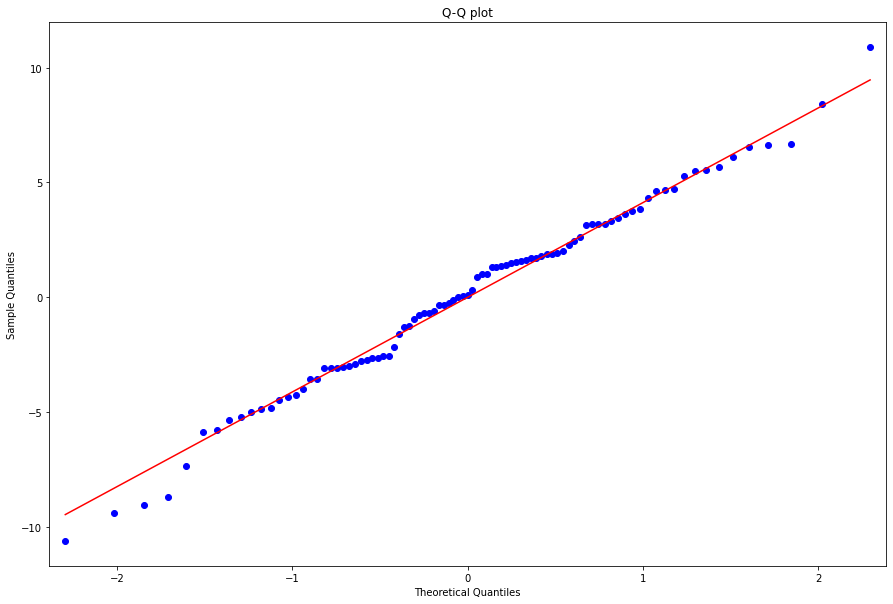

In [309]:
qqplot(results, line='s')
plt.rcParams['figure.figsize'] = [3, 3]
plt.title('Q-Q plot')
plt.show()

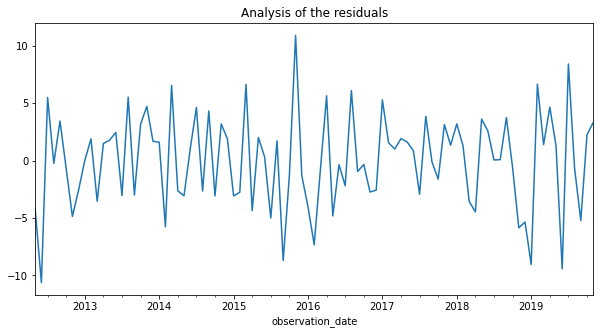

In [310]:
results.plot(figsize=(10,5))
plt.title('Analysis of the residuals')
plt.show()